# Land Type Classification using Sentinel-2 Satellite Images

#### This project focuses on leveraging Deep Neural Networks (DNNs) to classify different land types (such as agriculture, water, urban areas, desert, roads, and trees).

## Step 1: Data Collection:

#### EuroSAT is a well-known dataset of Sentinel-2 satellite images designed for land use and land cover classification.
Download dataset [EuroSAT Dataset (RGB)](https://madm.dfki.de/files/sentinel/EuroSAT.zip)

#### Path to the dataset: 'EuroSAT/2750/' with 10 subfolders each containing around 2000-3000 images.

## Step 2: Data Exploration:

In [ ]:
!pip install ultralytics
from IPython.display import clear_output
clear_output()

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import cv2
from collections import Counter
import tensorflow as tf
import torch
from sklearn.metrics import classification_report, confusion_matrix
import glob
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shutil
import random
from tqdm import tqdm
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.04G/2.04G [00:26<00:00, 83.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [ ]:
dataset_path = path+'/EuroSAT'
print(os.listdir(dataset_path))

['Forest', 'Industrial', 'Highway', 'test.csv', 'Residential', 'train.csv', 'SeaLake', 'validation.csv', 'Pasture', 'AnnualCrop', 'River', 'label_map.json', 'HerbaceousVegetation', 'PermanentCrop']


In [ ]:
# List all land type categories
categories = os.listdir(dataset_path)
categories

['AnnualCrop',
 'train.csv',
 'River',
 'PermanentCrop',
 'label_map.json',
 'Industrial',
 'Forest',
 'test.csv',
 'Highway',
 'validation.csv',
 'Residential',
 'Pasture',
 'SeaLake',
 'HerbaceousVegetation']

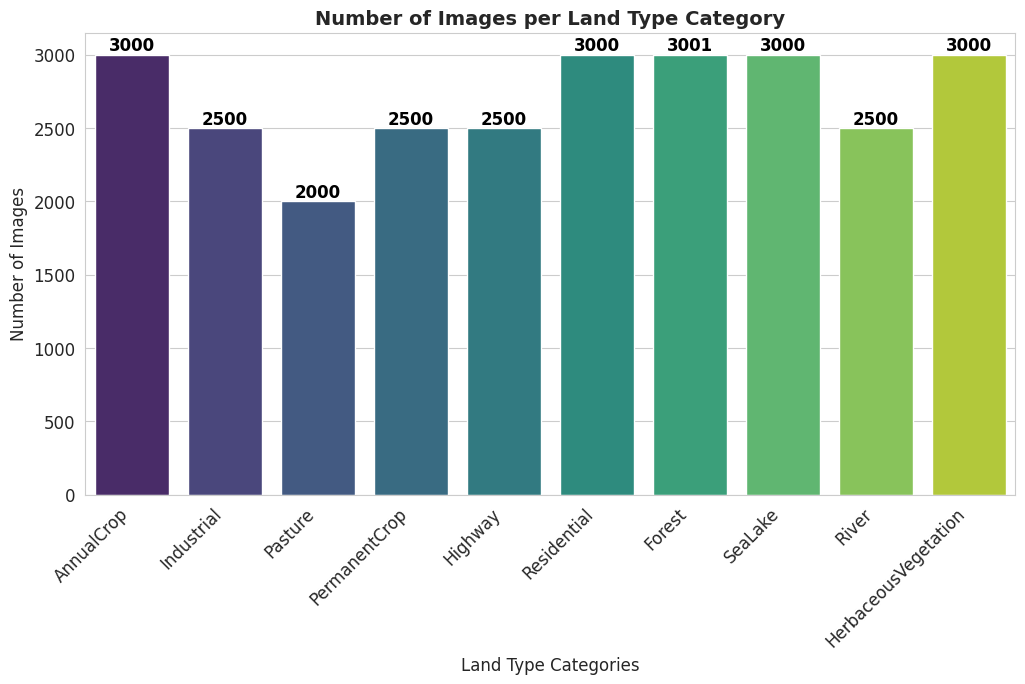

In [ ]:
# Count the number of images per category
image_count = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_count[category] = len(os.listdir(category_path))

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar plot (fix: assign `x` to `hue` and disable legend)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(image_count.keys()), y=list(image_count.values()), hue=list(image_count.keys()), palette="viridis", legend=False)

# Add exact counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Images per Land Type Category', fontsize=14, fontweight='bold')
plt.xlabel('Land Type Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Show the plot
plt.show()

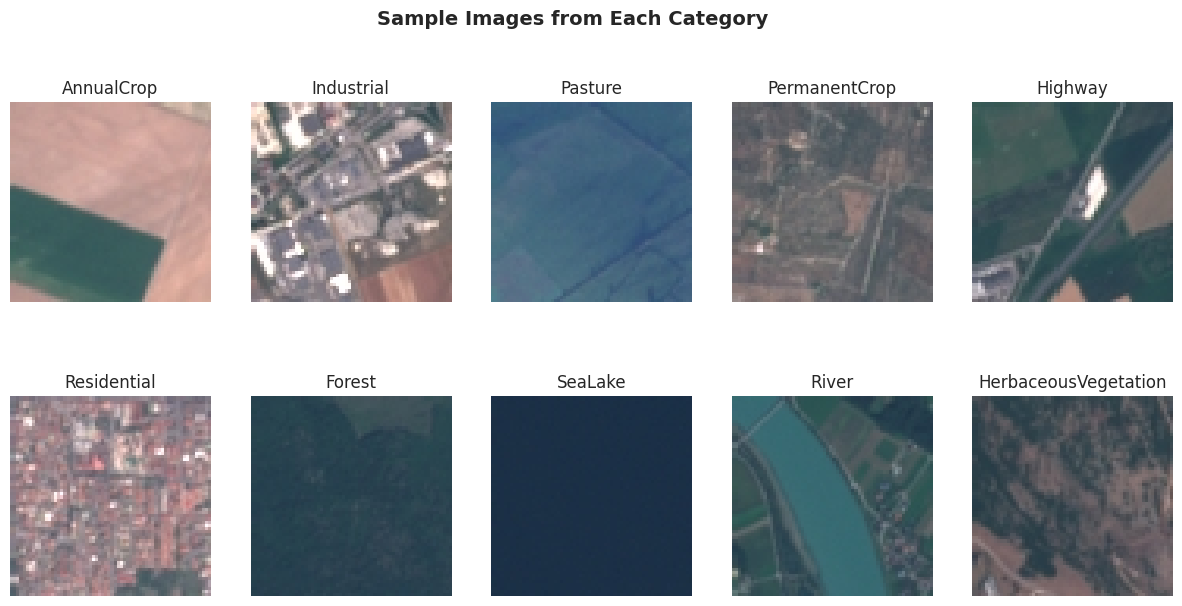

In [ ]:
# Visualize sample images from each category
plt.figure(figsize=(15, 7))
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    sample_image = os.listdir(category_path)[0]
    img = Image.open(os.path.join(category_path, sample_image))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.suptitle('Sample Images from Each Category', fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Check for missing data or corrupted images
def check_images(dataset_path):
    corrupted = []
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for img_name in os.listdir(category_path):
            try:
                img = Image.open(os.path.join(category_path, img_name))
                img.verify()
            except Exception as e:
                corrupted.append((category, img_name))
    return corrupted

In [ ]:
corrupted_images = check_images(dataset_path)
print(f"Number of corrupted images: {len(corrupted_images)}")
if corrupted_images:
    print("Corrupted images:", corrupted_images)

In [ ]:
import random
# Check image dimensions across classes
def check_image_dimensions(dataset_path, categories):
    dimensions = []

    for categories in categories:
        image_folder = os.path.join(dataset_path, categories)
        sample_image_path = os.path.join(image_folder, random.choice(os.listdir(image_folder)))

        img = cv2.imread(sample_image_path)
        dimensions.append(img.shape)  # Store dimensions (height, width, channels)

    unique_shapes = np.unique(dimensions, axis=0)
    print("Unique Image Dimensions Across Classes:", unique_shapes)

check_image_dimensions(dataset_path, categories)


# # Iterate through all images to check their dimensions
# for class_folder in os.listdir(dataset_path):
#     class_path = os.path.join(dataset_path, class_folder)
#     if os.path.isdir(class_path):
#         for img_name in os.listdir(class_path):
#             img_path = os.path.join(class_path, img_name)
#             img = Image.open(img_path)
#             image_shapes.append(img.size)

# # Check unique image sizes
# unique_sizes = set(all_shapes)
# print("Unique image sizes:", unique_sizes)

Unique Image Dimensions Across Classes: [[64 64  3]]


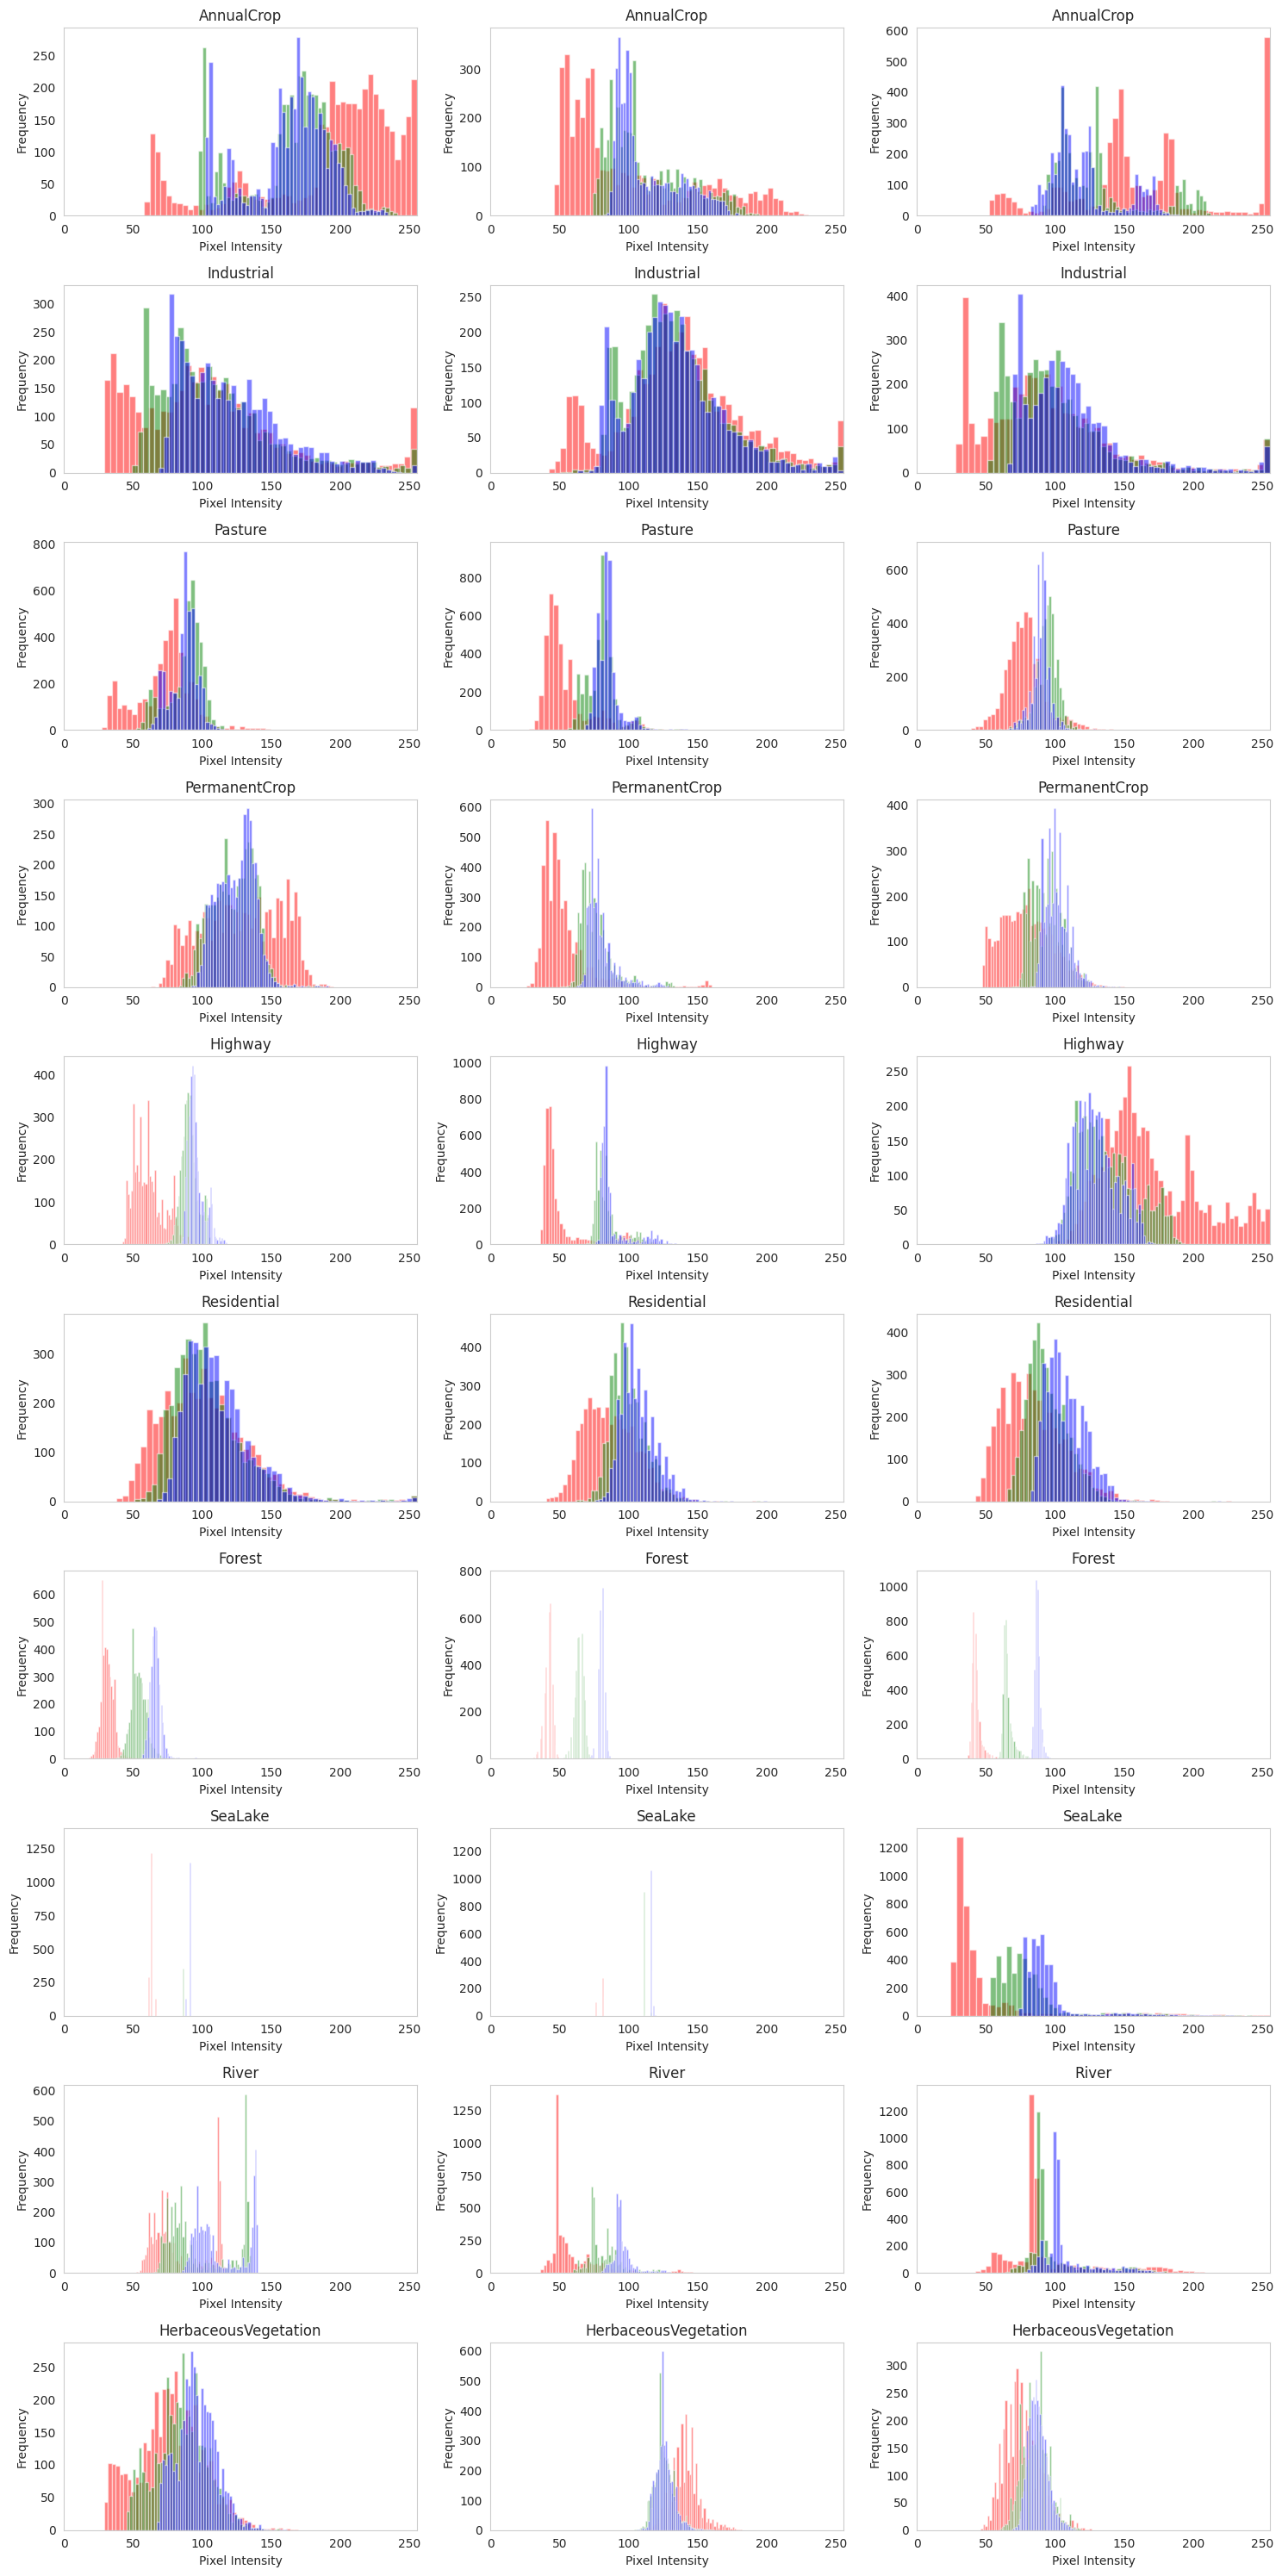

In [ ]:

import cv2
import os
import matplotlib.pyplot as plt
import math

# Function to plot pixel intensity distribution for each class
def plot_pixel_distribution(dataset_path, categories, num_samples=3):
    num_classes = len(categories)
    total_plots = num_classes * num_samples  # Total number of subplots

    # Define grid dynamically
    cols = min(num_samples, 3)  # Max 3 images per row for readability
    rows = math.ceil(total_plots / cols)  # Adjust rows accordingly

    plt.figure(figsize=(cols * 5, rows * 3))

    plot_idx = 1  # Track subplot index

    for category in categories:
        image_folder = os.path.join(dataset_path, category)

        # Ensure there are enough images to sample
        image_files = os.listdir(image_folder)
        sample_images = random.sample(image_files, min(num_samples, len(image_files)))

        for image_name in sample_images:
            img_path = os.path.join(image_folder, image_name)
            img = cv2.imread(img_path)

            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Ensure we don't exceed grid size
            if plot_idx > rows * cols:
                break

            plt.subplot(rows, cols, plot_idx)
            for channel, color in enumerate(['r', 'g', 'b']):
                plt.hist(img[:, :, channel].ravel(), bins=50, color=color, alpha=0.5)

            plt.title(f"{category}")
            plt.xlim([0, 255])
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")
            plt.grid(False)

            plot_idx += 1  # Move to next subplot

    plt.tight_layout()
    plt.show()

# Visualize pixel distributions
plot_pixel_distribution(dataset_path, categories)



**Key Observations from Pixel Intensity Distribution Analysis**

The histograms show the pixel intensity distributions for different land types in the EuroSat dataset. Each subplot represents a land type, and the Red, Green, and Blue channels are visualized separately.

1️⃣ **Distinct Patterns for Different Land Types**
* **Vegetation-Based Classes (AnnualCrop, Pasture, PermanentCrop, Forest, HerbaceousVegetation)**

Green channel (G) is dominant, indicating a higher reflection of green light.
Red and Blue channels have lower intensity distributions.

* **Urban and Man-Made Areas (Residential, Industrial, Highway)**

More balanced distributions across Red, Green, and Blue.
Industrial areas and highways have flatter histograms, indicating a mix of materials (e.g., concrete, asphalt).

* **Water Bodies (SeaLake, River)**

Strong peaks in the Blue channel, indicating high reflection of blue light.
Red and Green channels have relatively lower intensity values.

2️⃣ Overlapping Distributions in Some Land Types
* **AnnualCrop vs. PermanentCrop**

Both show similar patterns, meaning they might be harder to separate using RGB values alone.
NDVI (Normalized Difference Vegetation Index) could help in better distinguishing them.

* **Forest vs. HerbaceousVegetation**

Similar intensity ranges in all three channels.
Extra features like texture analysis or spectral indices could improve differentiation.

3️⃣ Unique Trends in Specific Classes

* **Highway**

Has a unique shape with peaks in all three channels, suggesting a mix of materials (asphalt, road markings, shadows).

* **SeaLake & River**

Strong Blue channel dominance but a secondary spike in the Green channel.
This pattern aligns with water reflectance properties in optical imagery.

4️⃣ **Potential Preprocessing Needs**

* **Contrast Differences**

Some classes have skewed distributions (e.g., Forest and River have clustered values).
Histogram equalization or contrast adjustments might help normalize variations.

* **Normalization for Model Training**

Standardizing intensity values across channels could improve model generalization.


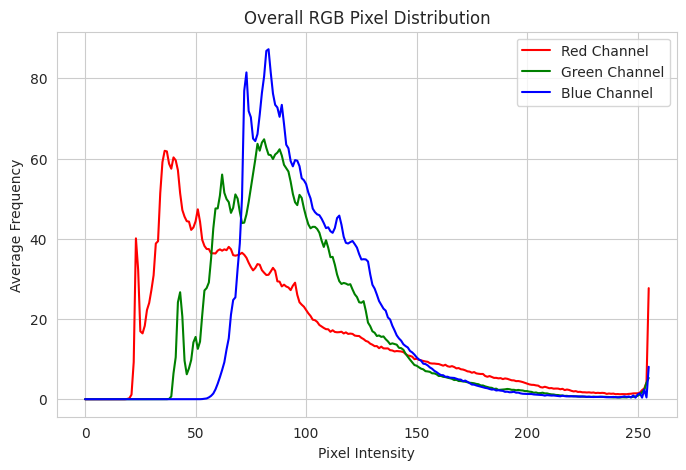

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def compute_pixel_distribution_optimized(dataset_path, categories, sample_size=None):
    total_hist_r = np.zeros(256)
    total_hist_g = np.zeros(256)
    total_hist_b = np.zeros(256)

    def process_image(img_path):
        img = cv2.imread(img_path)
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hist_r, _ = np.histogram(img[:, :, 0], bins=256, range=(0, 256))
        hist_g, _ = np.histogram(img[:, :, 1], bins=256, range=(0, 256))
        hist_b, _ = np.histogram(img[:, :, 2], bins=256, range=(0, 256))
        return hist_r, hist_g, hist_b

    image_paths = []
    for category in categories:
        class_folder = os.path.join(dataset_path, category)
        image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png'))]
        image_paths.extend(image_files)

    # Sample images if specified
    if sample_size:
        np.random.shuffle(image_paths)
        image_paths = image_paths[:sample_size]

    results = Parallel(n_jobs=-1)(delayed(process_image)(img_path) for img_path in image_paths)

    total_images = 0
    for res in results:
        if res is not None:
            hist_r, hist_g, hist_b = res
            total_hist_r += hist_r
            total_hist_g += hist_g
            total_hist_b += hist_b
            total_images += 1

    if total_images > 0:
        total_hist_r /= total_images
        total_hist_g /= total_images
        total_hist_b /= total_images

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(total_hist_r, color="red", label="Red Channel")
    plt.plot(total_hist_g, color="green", label="Green Channel")
    plt.plot(total_hist_b, color="blue", label="Blue Channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Average Frequency")
    plt.legend()
    plt.title("Overall RGB Pixel Distribution")
    plt.show()

# Compute pixel intensity distribution with optimizations
compute_pixel_distribution_optimized(dataset_path, categories, sample_size=500)  # Adjust sample size as needed


## 📊 Understanding the RGB Pixel Distribution Graph

### **Graph Explanation**
- **X-axis**: Represents **pixel intensity values** (0-255), where:
  - `0` → **Black** (lowest intensity)
  - `255` → **White** (highest intensity)
- **Y-axis**: Represents the **average frequency** of each intensity across all images.
- **Curves Represent Different Channels:**
  - 🔴 **Red Channel**
  - 🟢 **Green Channel**
  - 🔵 **Blue Channel**

### **📌 Key Insights from the Graph**
1. **Blue Dominance Around 80-100 Intensity**  
   - The blue curve has the highest peak around **80-100**.
   - This suggests that many images in the dataset contain **blueish tones** (e.g., water bodies, sky, or shadows).

2. **Green and Red Are More Spread Out**  
   - The **green curve** peaks between **50-100**, indicating the presence of **vegetation or natural elements**.
   - The **red curve** is more distributed, with peaks around **40-60**, suggesting the presence of **soil, buildings, or reddish tones**.

3. **Low Intensities (Shadows/Dark Areas)**  
   - The left side of the graph (0-50) shows noticeable activity in **red and green**, meaning some images have **dark or shadowed areas**.

4. **High Intensities (Bright Areas)**  
   - The right side of the graph (200-255) has lower values, meaning fewer **very bright areas** exist in the dataset.

## Step 3: Data Preprocessing:




In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [ ]:
# Define transformation (without normalization)
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors
])

In [ ]:
# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [ ]:
import torch

def compute_mean_std(loader):
    mean = torch.zeros(3, dtype=torch.float64)
    std = torch.zeros(3, dtype=torch.float64)
    num_pixels = 0

    for images, _ in loader:
        batch_samples = images.shape[0]
        num_pixels += batch_samples * images.shape[2] * images.shape[3]  # Height * Width * Batch size

        # Sum means and squared values per channel
        mean += images.sum(dim=[0, 2, 3])
        std += (images ** 2).sum(dim=[0, 2, 3])

    mean /= num_pixels
    std = torch.sqrt(std / num_pixels - mean ** 2)  # std = sqrt(E[x^2] - (E[x])^2)

    return mean.tolist(), std.tolist()

# 🚀 Run optimized function
mean, std = compute_mean_std(loader)

print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")


Dataset Mean: [0.34437597334826436, 0.38029085127512613, 0.40777030097113715]
Dataset Std: [0.20266076750715076, 0.136896595010445, 0.11555012942640239]


In [ ]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.BICUBIC, fill=128),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# transforms.Grayscale(num_output_channels=1),  # we not Convert to grayscaleabs
# Keep RGB because color carries meaningful features.

# transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # well crop alot of details from images

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.0054, 0.0059, 0.0064], std=[0.0023, 0.0017, 0.0014])  # Use computed values
# ])

#### Why These Specific Transformations?
Data augmentation helps improve model generalization by introducing variations in the training data. Here’s why each transformation is useful:

- **`transforms.RandomHorizontalFlip(p=0.5)`**  
  - Flips the image horizontally with a 50% chance.  
  - Useful for datasets where objects can appear in either left or right orientations.  

- **`transforms.RandomVerticalFlip(p=0.5)`**  
  - Flips the image vertically with a 50% chance.  
  - Helpful for satellite or aerial images where features might not have a fixed orientation.  

- **`transforms.RandomRotation(15)`**  
  - Rotates the image randomly by up to ±15 degrees.  
  - Helps the model learn rotation-invariant features, useful for real-world scenarios where objects might not always be perfectly aligned.  

- **`transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)`**  
  - Randomly adjusts brightness, contrast, saturation, and hue.  
  - Improves robustness to lighting variations and different weather conditions, making the model more adaptable to real-world images.  

These transformations enhance the diversity of the training data, reducing overfitting and improving the model’s performance. 🚀

- **`ToTensor()`** → Converts image to PyTorch tensor format.
- **`Normalize(mean, std)`** → Uses your dataset-specific values to improve model convergence and stability.

In [ ]:
# Load Dataset with Transformations
dataset = ImageFolder(root=dataset_path, transform=transform)

In [ ]:
# Split the Dataset
train_size = int(0.7 * len(dataset))  # 70% Training
val_size = int(0.2 * len(dataset))    # 20% Validation
test_size = len(dataset) - train_size - val_size  # 10% Test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Create DataLoaders
# DataLoaders help in loading batches efficiently during training:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_loader.dataset.dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

#### Visualizing Augmented Images
Since we've applied transformations (flipping, rotation, color jitter), it's essential to visualize the modified images to ensure they're applied correctly.

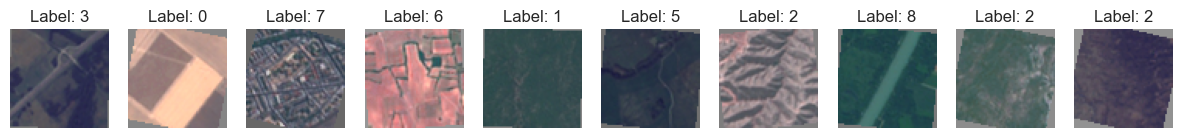

In [ ]:
# Function to Display Sample Images from Dataset
def show_images(dataset, mean, std, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Convert mean and std lists to NumPy arrays for element-wise operations
    mean = np.array(mean.tolist())  # Use mean.tolist() dynamically
    std = np.array(std.tolist())    # Use std.tolist() dynamically

    for i in range(num_images):
        img, label = dataset[i]
        img = img.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

        # Reverse normalization (denormalize)
        img = img * std + mean
        img = np.clip(img, 0, 1)  # Keep pixel values in valid range

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.show()

# Call function with dynamically computed mean & std
show_images(train_dataset, mean, std)

#### Class Distribution Visualization (After Preprocessing)

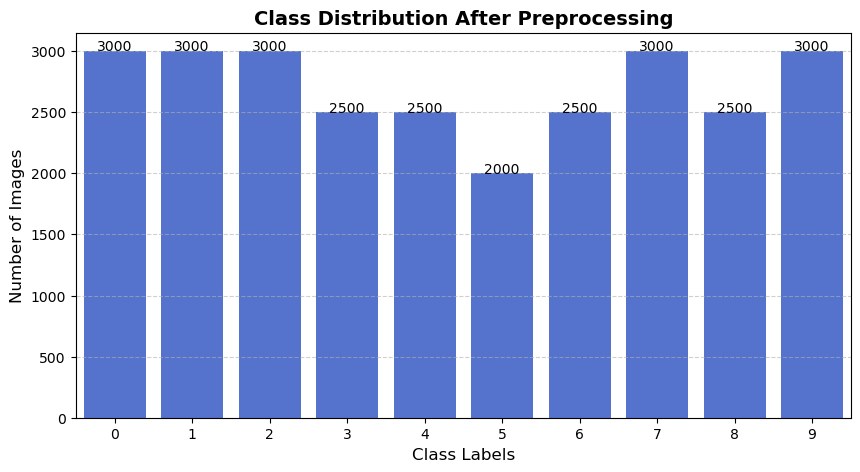

In [ ]:
# Extract class labels
labels = [label for _, label in dataset]  # Extract labels from dataset
label_counts = Counter(labels)

# Convert data into a format suitable for seaborn
data = {"Class Labels": list(label_counts.keys()), "Count": list(label_counts.values())}

# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x="Class Labels", y="Count", data=data, color="royalblue")

# Add labels & title
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Preprocessing", fontsize=14, fontweight="bold")

# Show counts on top of bars
for i, count in enumerate(label_counts.values()):
    plt.text(i, count + 2, str(count), ha="center", fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

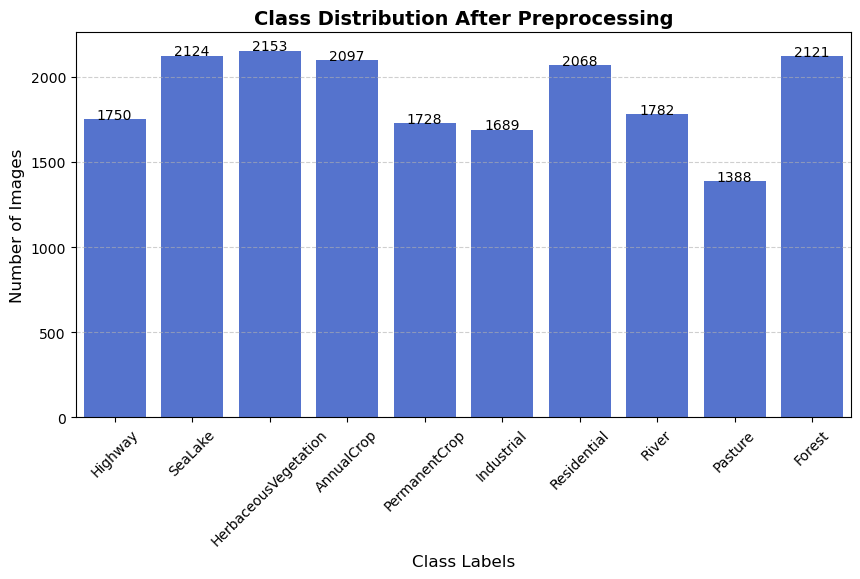

In [ ]:
# Extract class labels from the train dataset
labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
label_counts = Counter(labels)

# Convert to list format for seaborn
class_labels = [dataset.classes[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# Plot using Seaborn
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=class_labels, y=counts, color="royalblue")

# Add labels & title
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Preprocessing (Training Data)", fontsize=14, fontweight="bold")

# Show counts on top of bars
for i, count in enumerate(counts):
    ax.text(i, count + 2, str(count), ha="center", fontsize=10)

plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better visibility
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

# YOLO preprocessing

in This step prepares the EuroSAT dataset for training a YOLO model by organizing images and labels into train, val, and test sets.

📌 Steps:
1. Create necessary directories for storing images and labels in YOLO format.
2. Define class labels and map them to numerical values.
3. Split dataset into:

    - 80% for training
    - 17% for validation
    - 3% for testing (remaining data)

4. Convert annotations to YOLO format (x_center, y_center, width, height).
5. Save images & labels into corresponding directories.

🚀 Now the dataset is ready for YOLO training!

In [ ]:
# create the path of data
dataset_path = dataset_path
output_path = "/content/yolo_dataset"

os.makedirs(f"{output_path}/images/train", exist_ok=True)
os.makedirs(f"{output_path}/images/val", exist_ok=True)
os.makedirs(f"{output_path}/labels/train", exist_ok=True)
os.makedirs(f"{output_path}/labels/val", exist_ok=True)
os.makedirs(f"{output_path}/images/test", exist_ok=True)
os.makedirs(f"{output_path}/labels/test", exist_ok=True)


# EuroSAT classes
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
           'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
class_map = {cls: idx for idx, cls in enumerate(classes)}

# spliting
train_ratio = 0.8
val_ratio = 0.17

In [ ]:
def convert_to_yolo_format(image_size, bbox):
    x_center = (bbox[0] + bbox[2]) / 2.0 / image_size[0]
    y_center = (bbox[1] + bbox[3]) / 2.0 / image_size[1]
    width = (bbox[2] - bbox[0]) / image_size[0]
    height = (bbox[3] - bbox[1]) / image_size[1]
    return x_center, y_center, width, height

for class_name in tqdm(classes, desc="Processing"):
    image_files = glob.glob(f"{dataset_path}/{class_name}/*.jpg")
    random.shuffle(image_files)

    train_size = int(len(image_files) * train_ratio)
    val_size = int(len(image_files) * val_ratio)
    train_files, val_files = image_files[:train_size], image_files[train_size:]

    for i, file in enumerate(train_files + val_files):
        img = cv2.imread(file)
        h, w, _ = img.shape

        # YOLO expects bounding boxes
        bbox = [0, 0, w, h]
        yolo_bbox = convert_to_yolo_format((w, h), bbox)

        # save images
        subset = "train" if i < train_size else "val" if i < train_size + val_size else "test"
        img_name = os.path.basename(file)
        new_img_path = f"{output_path}/images/{subset}/{img_name}"
        shutil.copy(file, new_img_path)

        # save labeles
        label_path = f"{output_path}/labels/{subset}/{img_name.replace('.jpg', '.txt')}"
        with open(label_path, "w") as f:
            f.write(f"{class_map[class_name]} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n")

Processing: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


  # Yolo8

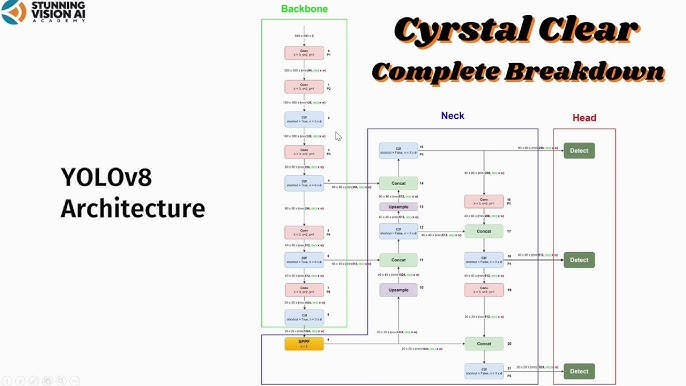

In [ ]:
yaml_content = f"""
path: {output_path}
train: images/train
val: images/val
test: images/test
nc: 10
names: {classes}
"""

with open(f"{output_path}/data.yaml", "w") as yaml_file:
    yaml_file.write(yaml_content)

In [ ]:
# Train the model
model = YOLO("yolov8s.pt")
model.train(data=f"{output_path}/data.yaml", epochs=20, patience=5, batch=16, imgsz=256, device="cuda")

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/yolo_dataset/data.yaml, epochs=20, time=None, patience=5, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /content/yolo_dataset/labels/train.cache... 21600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21600/21600 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_dataset/labels/val.cache... 4590 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4590/4590 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.19G      0.193      1.202     0.9411         48        256: 100%|██████████| 1350/1350 [03:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:22<00:00,  6.28it/s]

                   all       4590       4590       0.88      0.882      0.951       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.09G     0.1344     0.8631     0.9042         52        256: 100%|██████████| 1350/1350 [02:57<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:21<00:00,  6.58it/s]

                   all       4590       4590      0.869      0.877      0.944      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.09G     0.1179     0.7787     0.8991         39        256: 100%|██████████| 1350/1350 [02:51<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:22<00:00,  6.53it/s]

                   all       4590       4590      0.862      0.885      0.959      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.09G     0.1042     0.7365      0.895         47        256: 100%|██████████| 1350/1350 [02:50<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:22<00:00,  6.31it/s]

                   all       4590       4590      0.856      0.906      0.969      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       1.1G    0.09203     0.6762     0.8937         42        256: 100%|██████████| 1350/1350 [02:48<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:22<00:00,  6.27it/s]

                   all       4590       4590      0.792      0.863      0.918      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.09G    0.08405     0.6393     0.8928         51        256: 100%|██████████| 1350/1350 [02:48<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:21<00:00,  6.74it/s]

                   all       4590       4590      0.909      0.934      0.982      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.09G    0.07713     0.6092     0.8913         53        256: 100%|██████████| 1350/1350 [02:50<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:22<00:00,  6.44it/s]

                   all       4590       4590      0.912      0.936      0.982      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.08G    0.07205     0.5771     0.8892         46        256: 100%|██████████| 1350/1350 [02:49<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:23<00:00,  6.24it/s]

                   all       4590       4590      0.917      0.925      0.979      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.09G    0.06798     0.5649     0.8901         50        256: 100%|██████████| 1350/1350 [02:49<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:21<00:00,  6.72it/s]

                   all       4590       4590      0.953      0.959      0.989      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       1.1G    0.06362     0.5408     0.8896         53        256: 100%|██████████| 1350/1350 [02:51<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:21<00:00,  6.65it/s]

                   all       4590       4590      0.964      0.952      0.989      0.989


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.09G    0.04866     0.3867     0.9027         16        256:  43%|████▎     | 585/1350 [01:11<01:45,  7.27it/s]

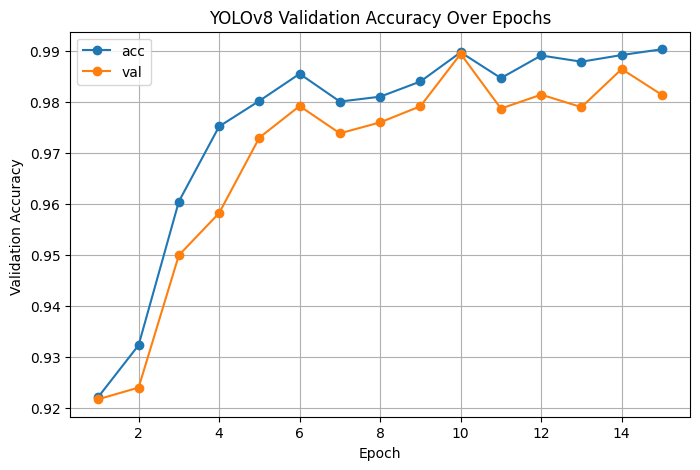

In [ ]:
# plot the accuary of training model
results_path = "/content/runs/detect/train/results.csv"
df = pd.read_csv(results_path)

# plot accuary
plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], marker="o", linestyle="-", label="acc")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], marker="o", linestyle="-", label="val")


plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy ")
plt.title("YOLOv8 Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

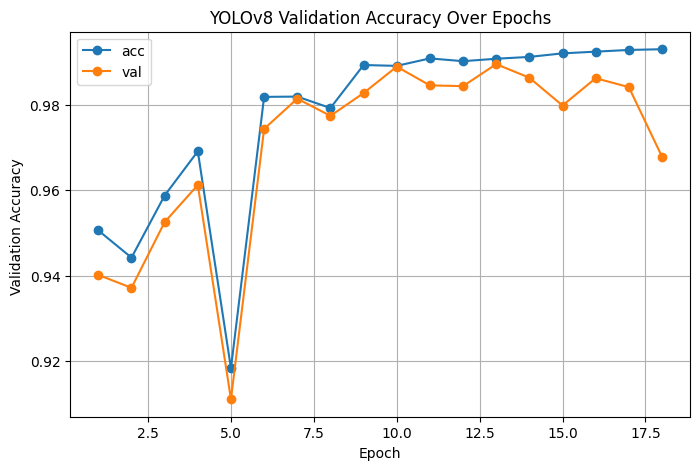

In [ ]:
# plot the accuary of training model
results_path = "/content/runs/detect/train/results.csv"
df = pd.read_csv(results_path)

# plot accuary
plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], marker="o", linestyle="-", label="acc")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], marker="o", linestyle="-", label="val")


plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy ")
plt.title("YOLOv8 Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

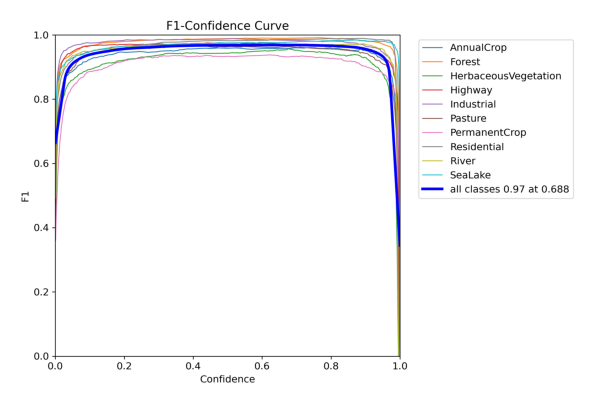

In [ ]:
f1_curve = "/content/runs/detect/train/F1_curve.png"
plt.figure(figsize=(8, 5))
plt.imshow(plt.imread(f1_curve))
plt.axis("off")
plt.show()

In [ ]:
# save model
model.save("/content/drive/MyDrive/DEPI/Final Project Depi/yolo_1.pt")

# Testing

In [ ]:
# improt saved model
model = YOLO("/content/drive/MyDrive/DEPI/Final Project Depi/yolo.pt")

In [ ]:
image_path = "/content/yolo_dataset/images/test"
test_images = glob.glob(os.path.join(image_path, "*.jpg"))

# Get true labels from image filenames (assuming the format: ClassName_ImageNumber.jpg)
y_true = [os.path.basename(img).split('_')[0] for img in test_images]

y_pred = []

for img in test_images:
    results = model(img)  # Predict on a single image

    # Check if any predictions were made
    if results[0].boxes.shape[0] > 0:
        pred_label = int(results[0].boxes.cls[0].item())  # Get predicted class index as a number

        # Convert predicted index to class name using your 'classes' list
        pred_label = classes[pred_label]  # Map index to class name
    else:
        pred_label = "Unknown"  # Or any other placeholder for no detections

    y_pred.append(pred_label)

clear_output()

In [ ]:
# Print the classification report and confusion matrix
print(classification_report(y_true, y_pred, target_names=classes))
print(confusion_matrix(y_true, y_pred))

                      precision    recall  f1-score   support

          AnnualCrop       0.99      0.94      0.97        90
              Forest       0.97      0.99      0.98        90
HerbaceousVegetation       0.92      0.90      0.91        90
             Highway       0.99      0.97      0.98        75
          Industrial       0.97      0.96      0.97        75
             Pasture       0.93      0.92      0.92        60
       PermanentCrop       0.96      0.91      0.93        75
         Residential       0.89      1.00      0.94        90
               River       0.96      0.97      0.97        75
             SeaLake       1.00      0.99      0.99        90

            accuracy                           0.96       810
           macro avg       0.96      0.96      0.96       810
        weighted avg       0.96      0.96      0.96       810

[[85  0  0  1  0  3  1  0  0  0]
 [ 0 89  0  0  0  0  0  0  1  0]
 [ 0  3 81  0  0  0  0  5  1  0]
 [ 0  0  0 73  1  0  0  1  0  


image 1/1 /content/Residential_1004.jpg: 256x256 1 Residential, 491.9ms
Speed: 1.1ms preprocess, 491.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 256)


array([[[  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204],
        ...,
        [  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204]],

       [[  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204],
        ...,
        [  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204]],

       [[  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204],
        ...,
        [  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204]],

       ...,

       [[  0, 237, 204],
        [  0, 237, 204],
        [ 62, 148, 134],
        ...,
        [ 66, 146, 129],
        [  0, 237, 204],
        [  0, 237, 204]],

       [[  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204],
        ...,
        [  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204]],

       [[  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204],
        ...,
        [  0, 237, 204],
        [  0, 237, 204],
        [  0, 237, 204]]], dtype=uint8)
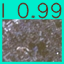

In [ ]:
# test one image from path
results = model("/content/Residential_1004.jpg")
results[0].plot()